In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

In [2]:
def plot_PEG(ax):
    ax.set_xlabel("Finger Prick Measured Concentration [mg/dL]",fontsize=13.5)
    ax.set_ylabel("Predicted Concentration [mg/dL]",fontsize=13.5)
    ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450 , 500,550],fontsize=20)
    ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450 , 500,550],fontsize=20)
    ax.set_facecolor('white')

    #Set axes lengths
    ax.set_xlim([0, 400])
    ax.set_ylim([0, 400])
    ax.set_aspect((550)/(550))
    
    color = 'black'
    #Plot zone lines
    ax.plot([0,550], [0,550], ':', c=color)          

    #B upper
    ax.plot([0, 30], [50, 50], '-', c=color)
    ax.plot([30, 230], [50, 330], '-', c=color)
    ax.plot([230, 440], [330, 550], '-', c=color)
    
    #B lower
    ax.plot( [50, 50],[0, 30], '-', c=color)
    ax.plot( [50, 90],[30, 80], '-', c=color)
    ax.plot( [90, 330],[80, 230], '-', c=color)
    ax.plot( [330, 550],[230, 450], '-', c=color)

    #C lower
    ax.plot([90, 260], [0, 130], '-', c=color)
    ax.plot([260, 550], [130, 250], '-', c=color)
    #C upper
    ax.plot([0, 30], [60, 60], '-', c=color)
    ax.plot([30, 280], [60, 550], '-', c=color)

    #D upper
    ax.plot([0, 25], [80, 80], '-', c=color)
    ax.plot([25, 35], [80, 90], '-', c=color)
    ax.plot([35, 125], [90, 550], '-', c=color)
    #D lower
    ax.plot([250, 250], [0, 40], '-', c=color)
    ax.plot([250, 410], [40, 110], '-', c=color)
    ax.plot([410, 550], [110, 160], '-', c=color)

    #E upper 
    ax.plot([0, 35], [200, 200], '-', c=color)
    ax.plot([35, 50], [200, 550], '-', c=color)

    #Add zone titles

    letter_size=22
    ax.text(300, 350, "A", fontsize=letter_size, c=color)
    ax.text(200, 350, "B", fontsize=letter_size, c=color)
    ax.text(125, 350, "C", fontsize=letter_size, c=color)
    ax.text(50, 350, "D", fontsize=letter_size, c=color)
    ax.text(10, 350, "E", fontsize=letter_size, c=color)
    ax.text(350, 20, "D", fontsize=letter_size, c=color)
    ax.text(350, 125, "C", fontsize=letter_size, c=color)
    ax.text(350, 200, "B", fontsize=letter_size, c=color)
    return ax


In [3]:
import numpy as np

def mard(actual, predicted, ignore_zero=True):
    """
    Compute Mean Absolute Relative Difference (MARD) in percent.
    
    Parameters
    ----------
    actual : array-like
        Reference glucose values.
    predicted : array-like
        Meter/algorithm glucose values (same shape as actual).
    ignore_zero : bool, default True
        If True, excludes any pairs where actual == 0 to avoid division by zero.
    
    Returns
    -------
    float
        MARD = 100 * mean( |predicted - actual| / actual ).
    """
    actual = np.asarray(actual, dtype=float)
    predicted = np.asarray(predicted, dtype=float)
    
    if actual.shape != predicted.shape:
        raise ValueError("`actual` and `predicted` must have the same shape.")
    
    # Compute absolute relative differences
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_diff = np.abs((predicted - actual) / actual)
    
    # Optionally ignore zero‐reference points
    if ignore_zero:
        mask = actual != 0
        rel_diff = rel_diff[mask]
    
    # Compute mean, skip any NaNs
    return np.nanmean(rel_diff) * 100

def line_from_points(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    b=  y1 - m * x1 
    return m,b

def is_above_line(x1, y1, x2, y2,act,pred):
    m,b = line_from_points(x1, y1, x2, y2)
    boundary_y = m*act+b  #y=mx+b
    #print('boundary_y: {} vs pred: {}'.format(boundary_y, pred) )
    if pred > boundary_y:
        return True
    else:
        return False

def get_PEG_Zone(act,pred):
    # Zone E
    if (pred > 200 and is_above_line(35, 200, 50, 550,act,pred)):
        return 7

    # Zone D - left upper
    if pred > 80:
        if act<=25:
            return 6
        if act>25 and act<=35 and is_above_line(25, 80, 35, 90,act,pred):
            return 6
        if act>35 and act<=125 and is_above_line(35, 90, 125, 550,act,pred):
            return 6

    #ZoneC - left uper
    if pred > 60:
        if act <=30:
            return 5
        if act>30 and is_above_line(30, 60, 280, 550,act,pred):
            return 5

    #ZoneB - left uper
    if pred > 50:
        if act <=30:
            return 4
        if act>30 and act <=230 and is_above_line(30, 50, 230, 330,act,pred):
            return 4
        if act>230 and  is_above_line(230, 330, 440, 550,act,pred):
            return 4

    #ZoneD - lower right
    if act >250:
        if act <= 410 and not is_above_line(250, 40, 410, 110,act,pred):
            return 3
        if act >410 and  not is_above_line(410, 110, 550, 160,act,pred):
            return 3

    #ZoneC - lower right
    if act >90:
        if act <= 260 and not is_above_line(90, 0, 260, 130,act,pred):
            return 2
        if act >260  and not is_above_line(260, 130, 550, 250,act,pred):
            return 2

    #ZoneB - lower right
    if act >50:
        if act <= 90 and not is_above_line(50, 30, 90, 80,act,pred):
            return 1
        if act >90 and act <=330  and not is_above_line(90, 80, 330, 230,act,pred):
            return 1
        if act >330 and  not is_above_line(330, 230, 550, 450,act,pred):
            return 1
    return 0

def get_zone_ration(zone):
    total = len(zone)
    A = zone.count('A')
    B =zone.count('B')+zone.count('b')
    C =zone.count('C')+zone.count('c')
    D =zone.count('D')+zone.count('d')
    E =zone.count('E')
    print("A:{:.2f}%, B:{:.2f}%, C:{:.2f}%, D:{:.2f}%, E:{:.2f}%,".format(A/total*100,B/total*100,C/total*100,D/total*100,E/total*100))

In [8]:

set1_target_Base_B = merge_all.loc[(merge_all['count_time']>=3)&
                     (merge_all['person_time_idx'].isin(noDM_drug_id))]['count'].unique()
set1_target_Base =np.concatenate([set1_target_Base_A,set1_target_Base_B])

set2_target_Base = list( merge_all.loc[(merge_all['count_time']>=3)&(merge_all['person_time_idx'].isin(DM_drug_id))]['count'].unique())


set3_target_Base = list( merge_all.loc[(merge_all['count_time']>=3)&(merge_all['person_time_idx'].isin(anyDM_drug_id))]['count'].unique())


total = np.concatenate([set1_target_Base,set2_target_Base,set3_target_Base])

# Cohort conditions

In [7]:
merge_all = pd.read_csv("/data/dp2/data/justin/data/merge_all_norm_resp_20191203-20.csv")
merge_all=merge_all.loc[merge_all['Time']==0]


BL_drug_cond=(merge_all['BL_drug']==0)
BP_drug_cond=(merge_all['BP_drug']==0)
DM_drug_cond=(merge_all['DM_drug']==0)
DM_inject_cond=(merge_all['DM_inject']==0)
O_drug_cond=(merge_all['O_drug']==0)

noDM_drug_id = merge_all.loc[(merge_all['Time']==0)&(DM_drug_cond)&DM_inject_cond]['person_time_idx']  #不含糖尿藥物

DM_drug_id = merge_all.loc[(merge_all['Time']==0)&
                           BL_drug_cond&BP_drug_cond&
                           (~DM_drug_cond)&DM_inject_cond&
                           O_drug_cond]['person_time_idx']  #不含胰島素

anyDM_drug_id=merge_all.loc[(merge_all['Time']==0)&(~BL_drug_cond|~BP_drug_cond|~O_drug_cond)&
                           (~DM_drug_cond&DM_inject_cond)]['person_time_idx'] # 有服用血糖藥 或 有胰島素注射 同時混用其他藥物


set1_target_Base_A = merge_all.loc[(merge_all['count_time']>=2)&(merge_all['count_time']<3)&
                     (merge_all['HbA1C']>6.5)&
                     (merge_all['person_time_idx'].isin(noDM_drug_id))]['count'].unique()

set1_target_Base_B = merge_all.loc[(merge_all['count_time']>=3)&
                     (merge_all['person_time_idx'].isin(noDM_drug_id))]['count'].unique()
set1_target_Base =np.concatenate([set1_target_Base_A,set1_target_Base_B])

set2_target_Base = list( merge_all.loc[(merge_all['count_time']>=3)&(merge_all['person_time_idx'].isin(DM_drug_id))]['count'].unique())


set3_target_Base = list( merge_all.loc[(merge_all['count_time']>=3)&(merge_all['person_time_idx'].isin(anyDM_drug_id))]['count'].unique())

print("SET 1 符合條件受測者共 {} 人".format(len(set1_target_Base)))
print(set1_target_Base )

SET 1 符合條件受測者共 19 人
[ 235.  897. 1009.  245.  342. 1768. 1628.  920.  789. 1486. 1725. 1726.
 1592. 1891.  745.  182. 1304.  245.  342.]


# Set1

In [11]:
implicit_df = pd.read_pickle("2024_ImplicitHbA1c_set1.pkl")
implicit_df=implicit_df.rename(columns={'pair_detail':'pair'})

In [12]:
output_df_hist = pd.DataFrame()
delta_days_list=[]
Person_No_base=[]
Person_No_test=[]
pretest_BG_ref=[]

profile = {'Age':[],'Gender':[],"SYS":[],"DIA":[],"HbA1C":[]}

for pid in set(set1_target_Base):
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set1-{}".format(pid))
    output_df_hist = pd.concat([output_df_hist,data_df])
    
#remove 2398_0942 from pid 342 who took DM drug later on
output_df_hist=output_df_hist.loc[~output_df_hist.pair.str.contains('2398_0942')] 
print("raw prediciton results",output_df_hist.shape)

output_df_hist=pd.merge(output_df_hist,implicit_df[['pair','Pred_BG_impHbA1c','pred_reject_score']],on='pair')
output_df_hist['error'] = abs(output_df_hist['ref_BG'] - output_df_hist['pred_BG'] )/output_df_hist['ref_BG']
output_df_hist['scaled_std'] = output_df_hist['std']/output_df_hist['pred_BG']
output_df_hist['pred_diff'] = abs(output_df_hist['Pred_BG_impHbA1c']-output_df_hist['pred_BG'])/output_df_hist['pred_BG']

SET1_summary_df=output_df_hist

SET1_summary_df=SET1_summary_df.loc[abs(SET1_summary_df['delta_days'])<=90]
print("Within 90 days",SET1_summary_df.shape)

SET1_summary_df=SET1_summary_df.loc[SET1_summary_df['pred_BG']>=50]
print("after removed faulty (<50 mg/dl predicitons)",SET1_summary_df.shape)


SET1_summary_df= SET1_summary_df.rename(columns={'delta_days':'date_since_baseline'})


SET1_summary_df=SET1_summary_df.loc[SET1_summary_df['scaled_std']<=0.2]
print("After screening",SET1_summary_df.shape)

split_df = SET1_summary_df['pair'].str.split("_", expand=True)
split_df.columns = ["A", "B", "C", "D"]

SET1_summary_df['base_pid'] = split_df["A"] + "_" + split_df["B"]
SET1_summary_df['test_pid'] = split_df["C"] + "_" + split_df["D"]
SET1_summary_df=SET1_summary_df.merge(merge_all[['person_time_idx', 'BG']],
                                      left_on='base_pid',right_on='person_time_idx', how='left')

Y=list(SET1_summary_df['pred_BG'])
X=list(SET1_summary_df['ref_BG'])

Y_sub30 = list(SET1_summary_df.loc[SET1_summary_df['date_since_baseline']<=30]['pred_BG'])
X_sub30 = list(SET1_summary_df.loc[SET1_summary_df['date_since_baseline']<=30]['ref_BG'])
Z_sub30 = list(SET1_summary_df.loc[SET1_summary_df['date_since_baseline']<=30]['BG'])

Y_30to90 = list(SET1_summary_df.loc[SET1_summary_df['date_since_baseline']>30]['pred_BG'])
X_30to90 = list(SET1_summary_df.loc[SET1_summary_df['date_since_baseline']>30]['ref_BG'])
Z_30to90 = list(SET1_summary_df.loc[SET1_summary_df['date_since_baseline']>30]['BG'])

raw prediciton results (182, 7)
Within 90 days (112, 12)
after removed faulty (<50 mg/dl predicitons) (112, 12)
After screening (112, 12)


Overall MARD : 10.69521304095304
<30 Days MARD : 9.589013072122347
30-90 Days MARD : 13.030524086262282 

Overall Zone% :
A:96.43%, B:3.57%, C:0.00%, D:0.00%, E:0.00%,
<30 Days Zone% :
A:98.68%, B:1.32%, C:0.00%, D:0.00%, E:0.00%,
30-90 Days Zone% :
A:91.67%, B:8.33%, C:0.00%, D:0.00%, E:0.00%,


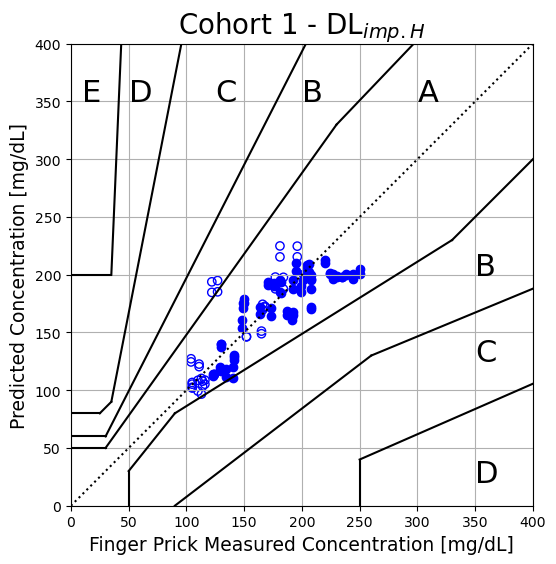

In [13]:
zone_class=['A','b','c','d','B','C','D','E']
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("Cohort 1 - DL$_{imp.H}$" , fontsize =20)
ax=plot_PEG(ax)

ax.scatter(X_sub30,Y_sub30,facecolor='blue',edgecolor='blue')
ax.scatter(X_30to90,Y_30to90,facecolor='none',edgecolor='blue')
plt.grid()


print("Overall MARD : {}".format(mard(X,Y)))
print("<30 Days MARD : {}".format(mard(X_sub30,Y_sub30)))
print("30-90 Days MARD : {} \n".format(mard(X_30to90,Y_30to90)))

zone=[]
for i in range(len(X)):
    zone.append(zone_class[get_PEG_Zone(X[i],Y[i])])
print('Overall Zone% :')
get_zone_ration(zone)

zone=[]
for i in range(len(X_sub30)):
    zone.append(zone_class[get_PEG_Zone(X_sub30[i],Y_sub30[i])])
print('<30 Days Zone% :')
get_zone_ration(zone)

zone=[]
for i in range(len(X_30to90)):
    zone.append(zone_class[get_PEG_Zone(X_30to90[i],Y_30to90[i])])
print('30-90 Days Zone% :')
get_zone_ration(zone)


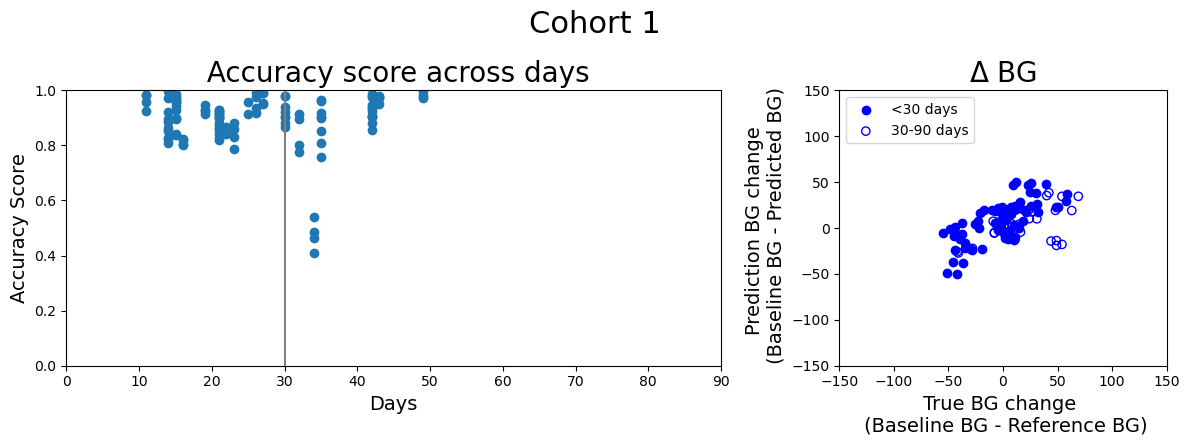

In [14]:
accuracy = 1-(abs(SET1_summary_df['ref_BG']-SET1_summary_df['pred_BG'])/SET1_summary_df['ref_BG'])
SET1_summary_df['accuracy']=accuracy

# Create figure with gridspec
fig = plt.figure(figsize=(12, 4.5), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[4,2])  # Left plot 3x wider than right

# Left subplot (Accuracy across days)
ax1 = plt.subplot(gs[0])
ax1.scatter(SET1_summary_df['date_since_baseline'], accuracy)
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Days", fontsize=14)
ax1.set_ylabel("Accuracy Score", fontsize=14)
ax1.set_title(" Accuracy score across days", fontsize=20)
#ax1.plot([0, 90], [0.8, 0.8], color='grey')
ax1.plot([30, 30], [0, 1], color='grey')

ax2 = plt.subplot(gs[1])

pred_diff_sub30= np.array(Z_sub30)-np.array(Y_sub30)
act_diff_sub30 = np.array(Z_sub30)-np.array(X_sub30)

pred_diff_30to90= np.array(Z_30to90 )-np.array(Y_30to90 )
act_diff_30to90 = np.array(Z_30to90 )-np.array(X_30to90 )

ax2.scatter(act_diff_sub30,pred_diff_sub30,label='<30 days',facecolor='blue',edgecolor ='blue')
ax2.scatter(act_diff_30to90,pred_diff_30to90,label='30-90 days',facecolor='none',edgecolor ='blue')

ax2.set_xlim(-150,150)
ax2.set_ylim(-150,150)
ax2.set_xlabel('True BG change \n (Baseline BG - Reference BG)', fontsize=14)
ax2.set_ylabel('Prediction BG change \n (Baseline BG - Predicted BG)', fontsize=14)
ax2.set_title("$\Delta$ BG" , fontsize =20)
ax2.legend(loc="upper left")

# Overall title
fig.suptitle("Cohort 1", fontsize=22)
plt.tight_layout()
plt.show()

In [15]:
summary_df =SET1_summary_df.loc[SET1_summary_df['date_since_baseline']<=30]
mean_accuracy_score =np.mean(1-abs(summary_df['ref_BG']-summary_df['pred_BG'])/summary_df['ref_BG'])
MAE = np.mean(abs(summary_df['ref_BG']-summary_df['pred_BG']))
MAPE = np.mean(abs(summary_df['ref_BG']-summary_df['pred_BG'])/summary_df['ref_BG'])
RMSE = np.sqrt(np.mean(np.square(summary_df['ref_BG']-summary_df['pred_BG'])))
PCC = np.corrcoef(summary_df['ref_BG'],summary_df['pred_BG'])[0][1]
print('mean_accuracy_score:',mean_accuracy_score)
print('MAE:',MAE)
print('MAPE:',MAPE*100)
print('RMSE:',RMSE)
print('PCC:',PCC)

mean_accuracy_score: 0.9041098692787768
MAE: 17.822140543084394
MAPE: 9.589013072122345
RMSE: 21.630195402747987
PCC: 0.8568253759823751


(0.0, 90.0)

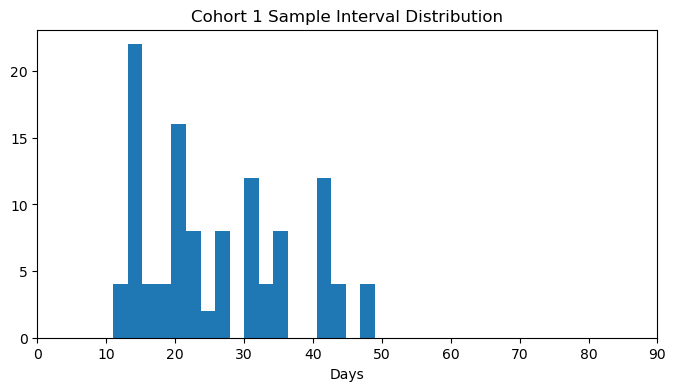

In [16]:
plt.figure(figsize=(8,4))
plt.hist(SET1_summary_df.loc[SET1_summary_df['date_since_baseline']<=90]['date_since_baseline'],bins=18)
plt.title('Cohort 1 Sample Interval Distribution')
plt.xlabel('Days')
plt.xlim(0,90)

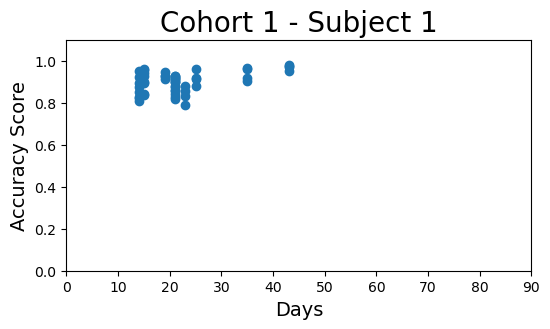

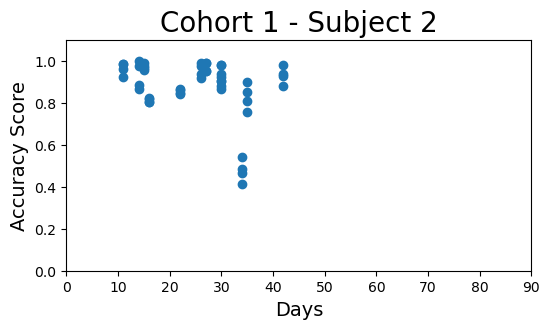

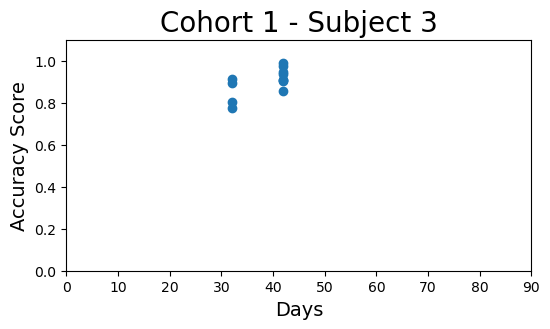

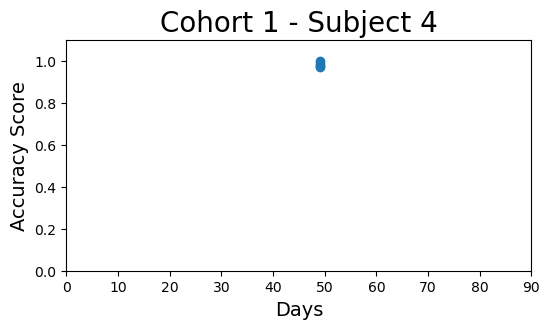

In [167]:
sample_count=[]
for pid in list(set(set1_target_Base)):
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set1-{}".format(pid))
    sample_count.append(data_df.loc[abs(data_df['delta_days'])<=90].shape[0])
    
top3_indices = [i for i, _ in sorted(enumerate(sample_count), key=lambda x: x[1], reverse=True)[:4]]
for n, pid in enumerate([list(set(set1_target_Base))[i] for i in top3_indices]):
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set1-{}".format(pid))
    time_interval=data_df['delta_days']
    Acc_score=1-abs(data_df['pred_BG']-data_df['ref_BG'])/data_df['ref_BG']
    plt.figure(figsize=(6,3))
    plt.title("Cohort 1 - Subject {}".format(n+1), fontsize=20)
    plt.scatter(time_interval,Acc_score)
    plt.xlim(0,90)
    plt.xlabel('Days', fontsize=14)
    plt.ylim(0,1.1)
    plt.ylabel("Accuracy Score", fontsize=14)
    plt.show()
    

342.0
(104, 13)


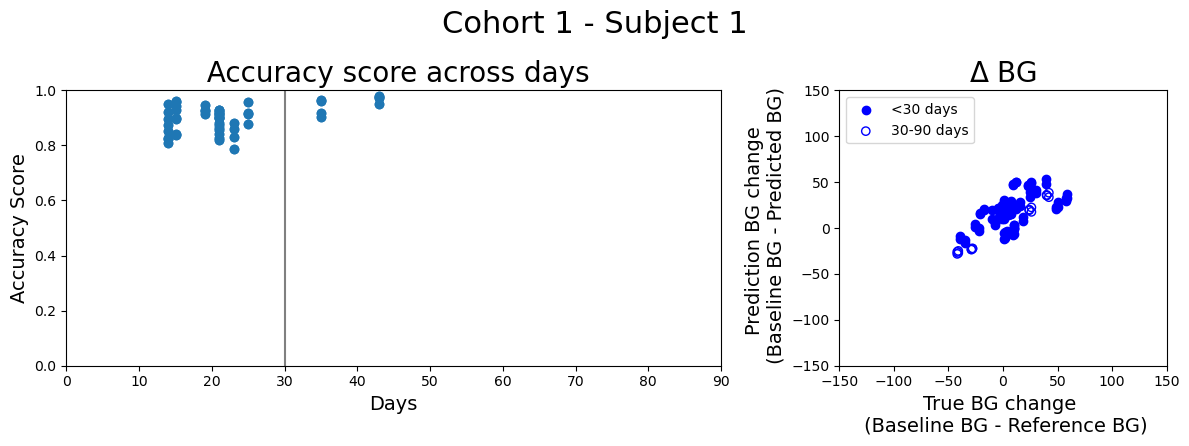

245.0
(96, 13)


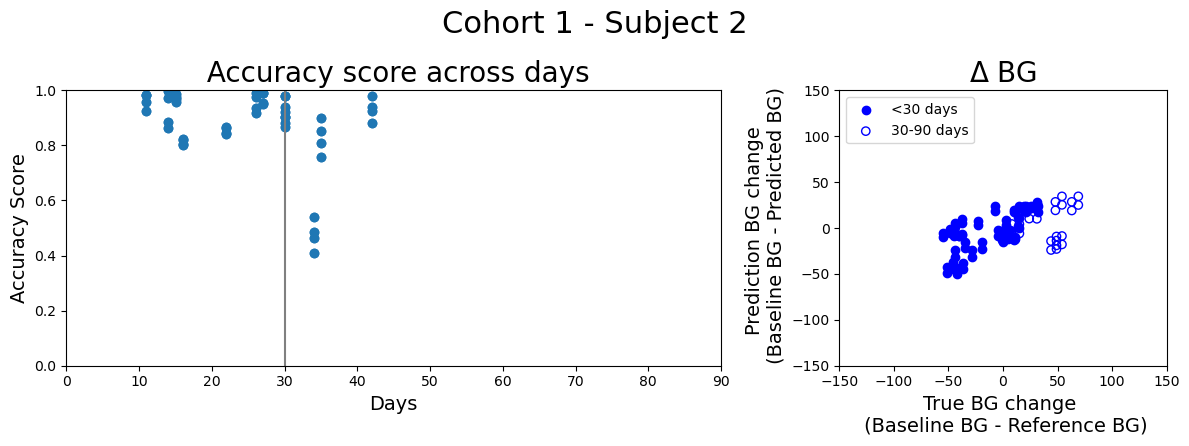

182.0
(32, 13)


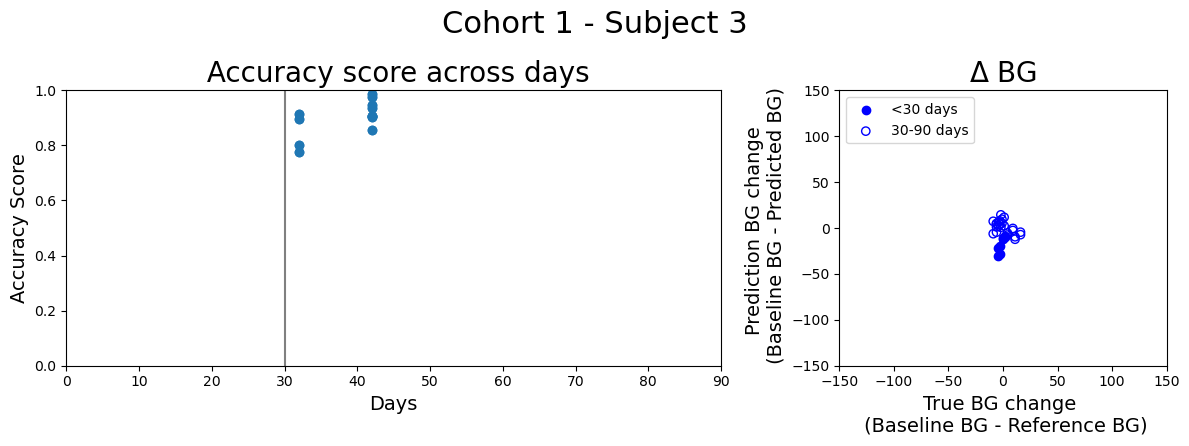

1768.0
(8, 13)


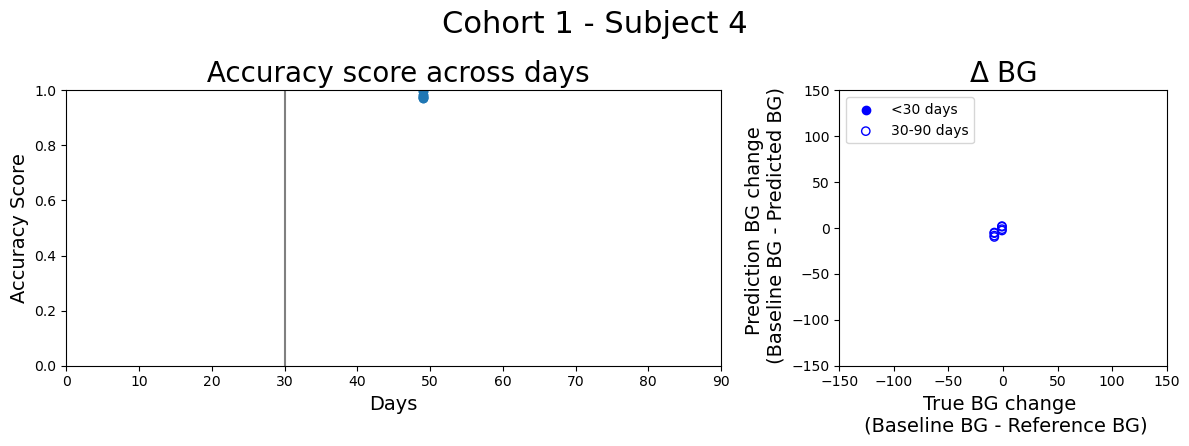

In [188]:


top3_indices = [i for i, _ in sorted(enumerate(sample_count), key=lambda x: x[1], reverse=True)[:4]]
for n, pid in enumerate([list(set(set1_target_Base))[i] for i in top3_indices]):
    print(pid)
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set1-{}".format(pid))  
    data_df[['pid_base', 'col2', 'pid_test', 'col4']] = data_df['pair'].str.split('_', expand=True).astype(int)
    data_df=data_df.merge(merge_all[['Person No', 'BG']],left_on='pid_base',right_on='Person No', how='left')
    data_df=data_df.loc[data_df['delta_days']<=90]
    print(data_df.shape)
    Acc_score=1-abs(data_df['pred_BG']-data_df['ref_BG'])/data_df['ref_BG']
    # Create figure with gridspec
    fig = plt.figure(figsize=(12, 4.5), dpi=100)
    gs = gridspec.GridSpec(1, 2, width_ratios=[4,2])  # Left plot 3x wider than right

    # Left subplot (Accuracy across days)
    ax1 = plt.subplot(gs[0])
    ax1.scatter(data_df['delta_days'], Acc_score)
    ax1.set_xlim(0, 90)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Days", fontsize=14)
    ax1.set_ylabel("Accuracy Score", fontsize=14)
    ax1.set_title(" Accuracy score across days", fontsize=20)
    #ax1.plot([0, 90], [0.8, 0.8], color='grey')
    ax1.plot([30, 30], [0, 1], color='grey')

    ax2 = plt.subplot(gs[1])
    
    Y_sub30 = list(data_df.loc[data_df['delta_days']<=30]['pred_BG'])
    X_sub30 = list(data_df.loc[data_df['delta_days']<=30]['ref_BG'])
    Z_sub30 = list(data_df.loc[data_df['delta_days']<=30]['BG'])

    Y_30to90 = list(data_df.loc[data_df['delta_days']>30]['pred_BG'])
    X_30to90 = list(data_df.loc[data_df['delta_days']>30]['ref_BG'])
    Z_30to90 = list(data_df.loc[data_df['delta_days']>30]['BG'])

    pred_diff_sub30= np.array(Z_sub30)-np.array(Y_sub30)
    act_diff_sub30 = np.array(Z_sub30)-np.array(X_sub30)

    pred_diff_30to90= np.array(Z_30to90 )-np.array(Y_30to90 )
    act_diff_30to90 = np.array(Z_30to90 )-np.array(X_30to90 )

    ax2.scatter(act_diff_sub30,pred_diff_sub30,label='<30 days',facecolor='blue',edgecolor ='blue')
    ax2.scatter(act_diff_30to90,pred_diff_30to90,label='30-90 days',facecolor='none',edgecolor ='blue')

    ax2.set_xlim(-150,150)
    ax2.set_ylim(-150,150)
    ax2.set_xlabel('True BG change \n (Baseline BG - Reference BG)', fontsize=14)
    ax2.set_ylabel('Prediction BG change \n (Baseline BG - Predicted BG)', fontsize=14)
    ax2.set_title("$\Delta$ BG" , fontsize =20)
    ax2.legend(loc="upper left")

    # Overall title
    fig.suptitle("Cohort 1 - Subject {}".format(n+1), fontsize=22)
    plt.tight_layout()
    plt.show()

# Set 2

In [104]:
implicit_df = pd.read_pickle("2024_ImplicitHbA1c_set2.pkl")
implicit_df=implicit_df.rename(columns={'pair_detail':'pair'})

In [105]:
output_df_hist = pd.DataFrame()
delta_days_list=[]
Person_No_base=[]
Person_No_test=[]
pretest_BG_ref=[]

profile = {'Age':[],'Gender':[],"SYS":[],"DIA":[],"HbA1C":[]}

for pid in set(set2_target_Base):
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set2-{}".format(pid))
    output_df_hist = pd.concat([output_df_hist,data_df])
    

print("raw prediciton results",output_df_hist.shape)

output_df_hist=pd.merge(output_df_hist,implicit_df[['pair','Pred_BG_impHbA1c','pred_reject_score']],on='pair')
output_df_hist['error'] = abs(output_df_hist['ref_BG'] - output_df_hist['pred_BG'] )/output_df_hist['ref_BG']
output_df_hist['scaled_std'] = output_df_hist['std']/output_df_hist['pred_BG']
output_df_hist['pred_diff'] = abs(output_df_hist['Pred_BG_impHbA1c']-output_df_hist['pred_BG'])/output_df_hist['pred_BG']


SET2_summary_df=output_df_hist

SET2_summary_df=SET2_summary_df.loc[abs(SET2_summary_df['delta_days'])<=90]
print("Within 90 days",SET2_summary_df.shape)

SET2_summary_df=SET2_summary_df.loc[SET2_summary_df['pred_BG']>=50]
print("after removed faulty (<50 mg/dl predicitons)",SET2_summary_df.shape)

SET2_summary_df= SET2_summary_df.rename(columns={'delta_days':'date_since_baseline'})


SET2_summary_df=SET2_summary_df.loc[SET2_summary_df['scaled_std']<=0.2]
print("After screening",SET2_summary_df.shape)

split_df = SET2_summary_df['pair'].str.split("_", expand=True)
split_df.columns = ["A", "B", "C", "D"]

SET2_summary_df['base_pid'] = split_df["A"] + "_" + split_df["B"]
SET2_summary_df['test_pid'] = split_df["C"] + "_" + split_df["D"]
SET2_summary_df=SET2_summary_df.merge(merge_all[['person_time_idx', 'BG']],
                                      left_on='base_pid',right_on='person_time_idx', how='left')

Y=list(SET2_summary_df['pred_BG'])
X=list(SET2_summary_df['ref_BG'])

Y_sub30 = list(SET2_summary_df.loc[SET2_summary_df['date_since_baseline']<=30]['pred_BG'])
X_sub30 = list(SET2_summary_df.loc[SET2_summary_df['date_since_baseline']<=30]['ref_BG'])
Z_sub30 = list(SET2_summary_df.loc[SET2_summary_df['date_since_baseline']<=30]['BG'])

Y_30to90 = list(SET2_summary_df.loc[SET2_summary_df['date_since_baseline']>30]['pred_BG'])
X_30to90 = list(SET2_summary_df.loc[SET2_summary_df['date_since_baseline']>30]['ref_BG'])
Z_30to90 = list(SET2_summary_df.loc[SET2_summary_df['date_since_baseline']>30]['BG'])

raw prediciton results (220, 7)
Within 90 days (158, 12)
after removed faulty (<50 mg/dl predicitons) (158, 12)
After screening (137, 12)


Overall MARD : 13.505735393732623
<30 Days MARD : 12.234858401951062
30-90 Days MARD : 14.687114005811264 

Overall Zone% :
A:92.70%, B:7.30%, C:0.00%, D:0.00%, E:0.00%,
<30 Days Zone% :
A:92.42%, B:7.58%, C:0.00%, D:0.00%, E:0.00%,
30-90 Days Zone% :
A:92.96%, B:7.04%, C:0.00%, D:0.00%, E:0.00%,


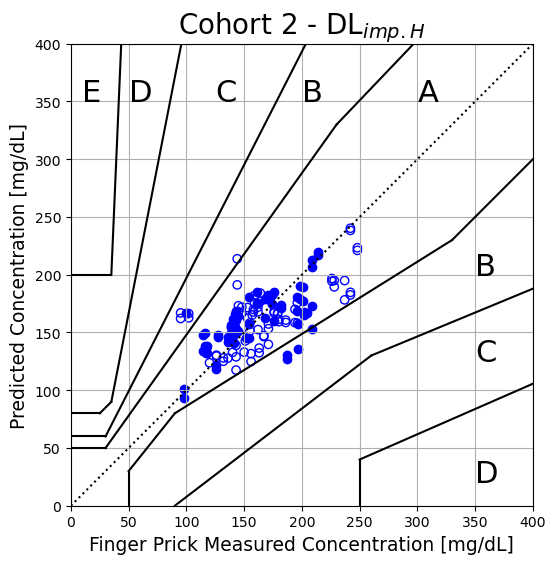

In [106]:
zone_class=['A','b','c','d','B','C','D','E']
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("Cohort 2 - DL$_{imp.H}$" , fontsize =20)
ax=plot_PEG(ax)

ax.scatter(X_sub30,Y_sub30,facecolor='blue',edgecolor='blue')
ax.scatter(X_30to90,Y_30to90,facecolor='none',edgecolor='blue')
plt.grid()


print("Overall MARD : {}".format(mard(X,Y)))
print("<30 Days MARD : {}".format(mard(X_sub30,Y_sub30)))
print("30-90 Days MARD : {} \n".format(mard(X_30to90,Y_30to90)))

zone=[]
for i in range(len(X)):
    zone.append(zone_class[get_PEG_Zone(X[i],Y[i])])
print('Overall Zone% :')
get_zone_ration(zone)

zone=[]
for i in range(len(X_sub30)):
    zone.append(zone_class[get_PEG_Zone(X_sub30[i],Y_sub30[i])])
print('<30 Days Zone% :')
get_zone_ration(zone)

zone=[]
for i in range(len(X_30to90)):
    zone.append(zone_class[get_PEG_Zone(X_30to90[i],Y_30to90[i])])
print('30-90 Days Zone% :')
get_zone_ration(zone)

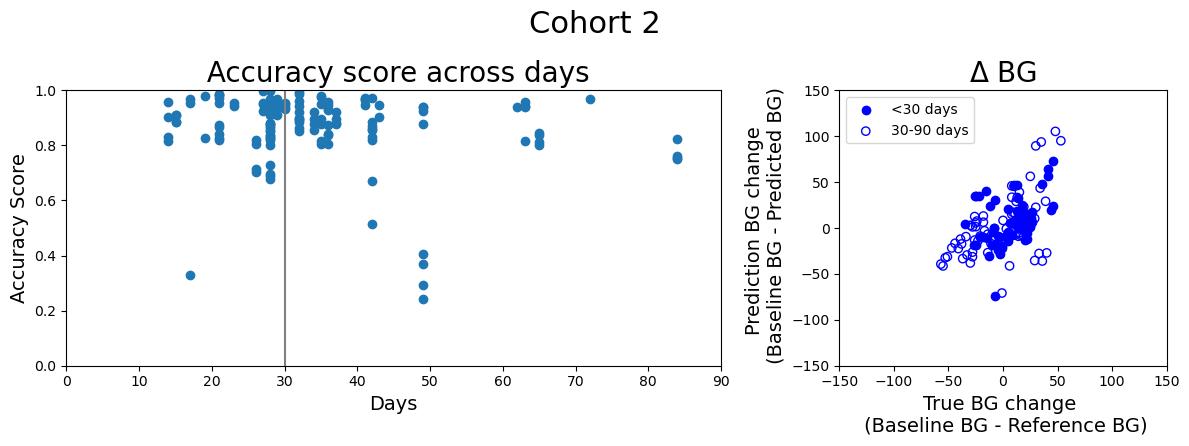

In [107]:
accuracy = 1-(abs(SET2_summary_df['ref_BG']-SET2_summary_df['pred_BG'])/SET2_summary_df['ref_BG'])
SET2_summary_df['accuracy']=accuracy

# Create figure with gridspec
fig = plt.figure(figsize=(12, 4.5), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[4,2])  # Left plot 3x wider than right

# Left subplot (Accuracy across days)
ax1 = plt.subplot(gs[0])
ax1.scatter(SET2_summary_df['date_since_baseline'], accuracy)
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Days", fontsize=14)
ax1.set_ylabel("Accuracy Score", fontsize=14)
ax1.set_title(" Accuracy score across days", fontsize=20)
#ax1.plot([0, 90], [0.8, 0.8], color='grey')
ax1.plot([30, 30], [0, 1], color='grey')

ax2 = plt.subplot(gs[1])

pred_diff_sub30= np.array(Z_sub30)-np.array(Y_sub30)
act_diff_sub30 = np.array(Z_sub30)-np.array(X_sub30)

pred_diff_30to90= np.array(Z_30to90 )-np.array(Y_30to90 )
act_diff_30to90 = np.array(Z_30to90 )-np.array(X_30to90 )

ax2.scatter(act_diff_sub30,pred_diff_sub30,label='<30 days',facecolor='blue',edgecolor ='blue')
ax2.scatter(act_diff_30to90,pred_diff_30to90,label='30-90 days',facecolor='none',edgecolor ='blue')

ax2.set_xlim(-150,150)
ax2.set_ylim(-150,150)
ax2.set_xlabel('True BG change \n (Baseline BG - Reference BG)', fontsize=14)
ax2.set_ylabel('Prediction BG change \n (Baseline BG - Predicted BG)', fontsize=14)
ax2.set_title("$\Delta$ BG" , fontsize =20)
ax2.legend(loc="upper left")

# Overall title
fig.suptitle("Cohort 2", fontsize=22)
plt.tight_layout()
plt.show()

In [108]:
summary_df =SET2_summary_df.loc[SET2_summary_df['date_since_baseline']<=30]
mean_accuracy_score =np.mean(1-abs(summary_df['ref_BG']-summary_df['pred_BG'])/summary_df['ref_BG'])
MAE = np.mean(abs(summary_df['ref_BG']-summary_df['pred_BG']))
MAPE = np.mean(abs(summary_df['ref_BG']-summary_df['pred_BG'])/summary_df['ref_BG'])
RMSE = np.sqrt(np.mean(np.square(summary_df['ref_BG']-summary_df['pred_BG'])))
PCC = np.corrcoef(summary_df['ref_BG'],summary_df['pred_BG'])[0][1]
print('mean_accuracy_score:',mean_accuracy_score)
print('MAE:',MAE)
print('MAPE:',MAPE*100)
print('RMSE:',RMSE)
print('PCC:',PCC)

mean_accuracy_score: 0.8776514159804895
MAE: 18.862048409201883
MAPE: 12.234858401951065
RMSE: 24.329648254018828
PCC: 0.6859113611685286


(0.0, 90.0)

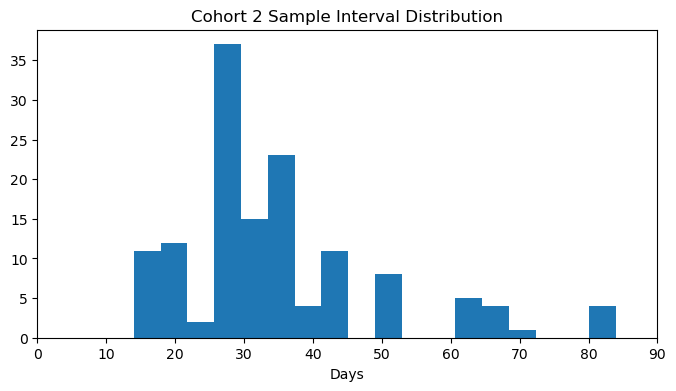

In [109]:
plt.figure(figsize=(8,4))
plt.hist(SET2_summary_df.loc[SET2_summary_df['date_since_baseline']<=90]['date_since_baseline'],bins=18)
plt.title('Cohort 2 Sample Interval Distribution')
plt.xlabel('Days')
plt.xlim(0,90)

In [111]:
sample_count

[34, 4, 12, 24, 36, 16, 12, 0, 16, 4]

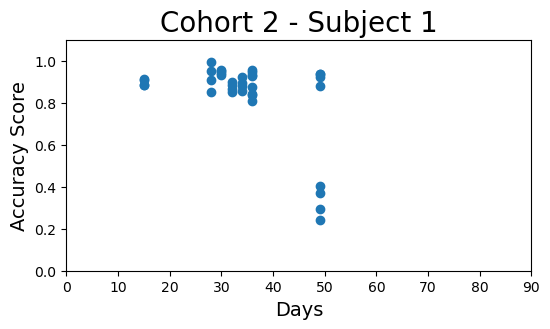

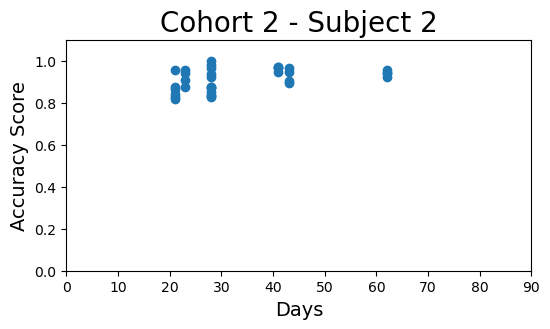

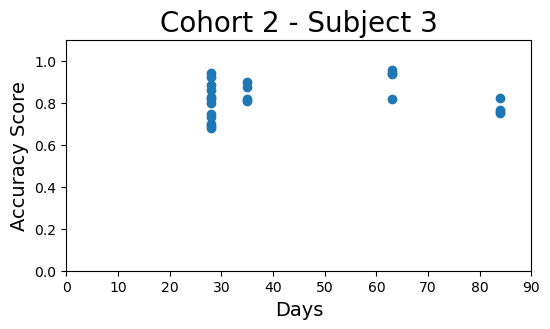

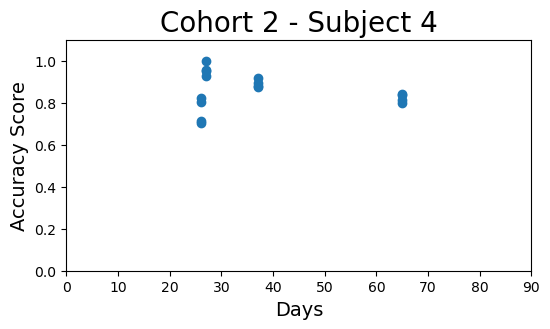

In [189]:
sample_count=[]
for pid in list(set(set2_target_Base)):
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set2-{}".format(pid))
    sample_count.append(data_df.loc[abs(data_df['delta_days'])<=90].shape[0])
    
top3_indices = [i for i, _ in sorted(enumerate(sample_count), key=lambda x: x[1], reverse=True)[:4]]
for n, pid in enumerate([list(set(set2_target_Base))[i] for i in top3_indices]):
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set2-{}".format(pid))
    time_interval=data_df['delta_days']
    Acc_score=1-abs(data_df['pred_BG']-data_df['ref_BG'])/data_df['ref_BG']
    plt.figure(figsize=(6,3))
    plt.title("Cohort 2 - Subject {}".format(n+1), fontsize=20)
    plt.scatter(time_interval,Acc_score)
    plt.xlim(0,90)
    plt.xlabel('Days', fontsize=14)
    plt.ylim(0,1.1)
    plt.ylabel("Accuracy Score", fontsize=14)
    plt.show()
    

1775.0
(72, 13)


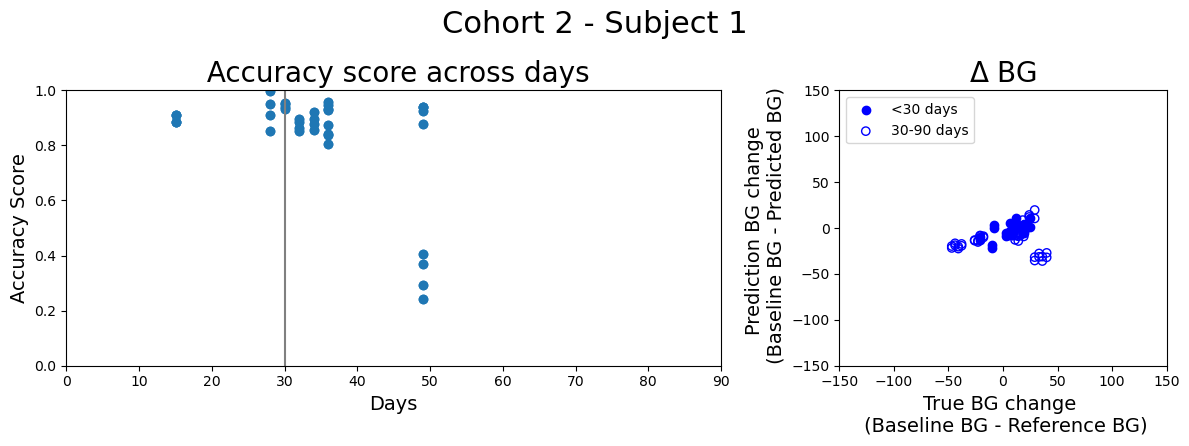

1888.0
(68, 13)


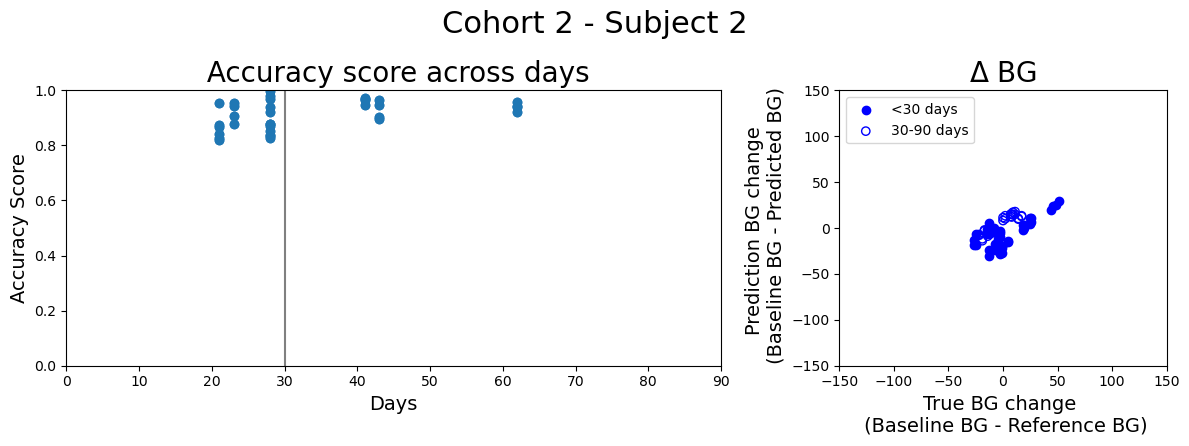

1483.0
(48, 13)


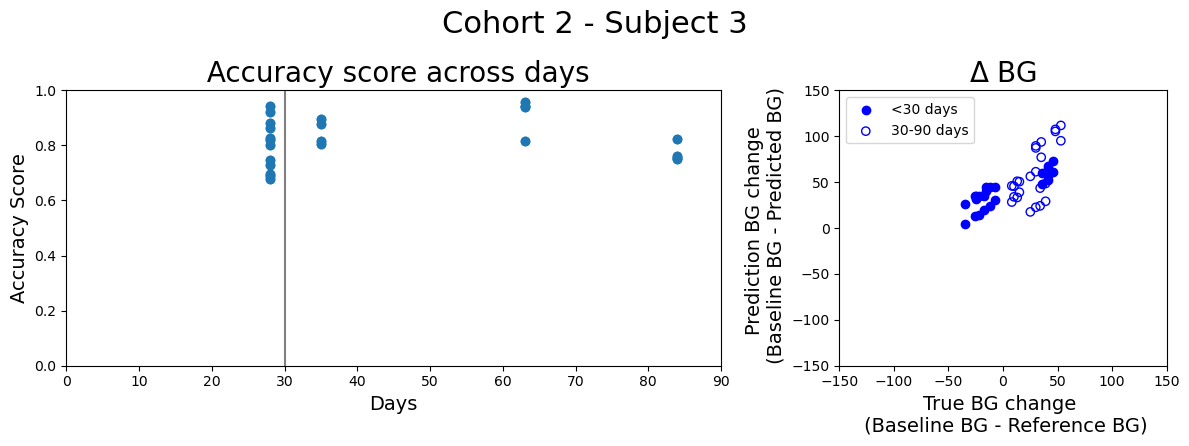

1202.0
(32, 13)


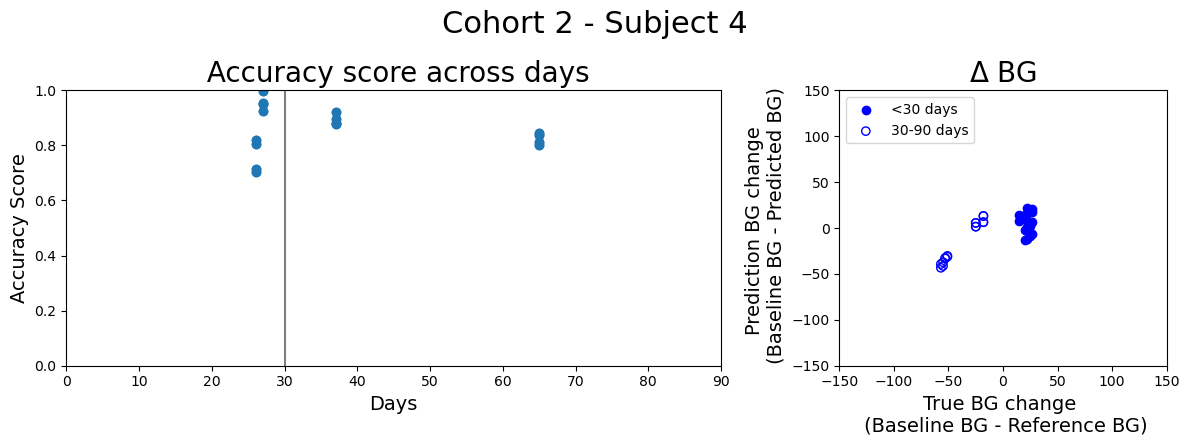

In [190]:


top3_indices = [i for i, _ in sorted(enumerate(sample_count), key=lambda x: x[1], reverse=True)[:4]]
for n, pid in enumerate([list(set(set2_target_Base))[i] for i in top3_indices]):
    print(pid)
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set2-{}".format(pid))  
    data_df[['pid_base', 'col2', 'pid_test', 'col4']] = data_df['pair'].str.split('_', expand=True).astype(int)
    data_df=data_df.merge(merge_all[['Person No', 'BG']],left_on='pid_base',right_on='Person No', how='left')
    data_df=data_df.loc[data_df['delta_days']<=90]
    print(data_df.shape)
    Acc_score=1-abs(data_df['pred_BG']-data_df['ref_BG'])/data_df['ref_BG']
    # Create figure with gridspec
    fig = plt.figure(figsize=(12, 4.5), dpi=100)
    gs = gridspec.GridSpec(1, 2, width_ratios=[4,2])  # Left plot 3x wider than right

    # Left subplot (Accuracy across days)
    ax1 = plt.subplot(gs[0])
    ax1.scatter(data_df['delta_days'], Acc_score)
    ax1.set_xlim(0, 90)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Days", fontsize=14)
    ax1.set_ylabel("Accuracy Score", fontsize=14)
    ax1.set_title(" Accuracy score across days", fontsize=20)
    #ax1.plot([0, 90], [0.8, 0.8], color='grey')
    ax1.plot([30, 30], [0, 1], color='grey')

    ax2 = plt.subplot(gs[1])
    
    Y_sub30 = list(data_df.loc[data_df['delta_days']<=30]['pred_BG'])
    X_sub30 = list(data_df.loc[data_df['delta_days']<=30]['ref_BG'])
    Z_sub30 = list(data_df.loc[data_df['delta_days']<=30]['BG'])

    Y_30to90 = list(data_df.loc[data_df['delta_days']>30]['pred_BG'])
    X_30to90 = list(data_df.loc[data_df['delta_days']>30]['ref_BG'])
    Z_30to90 = list(data_df.loc[data_df['delta_days']>30]['BG'])

    pred_diff_sub30= np.array(Z_sub30)-np.array(Y_sub30)
    act_diff_sub30 = np.array(Z_sub30)-np.array(X_sub30)

    pred_diff_30to90= np.array(Z_30to90 )-np.array(Y_30to90 )
    act_diff_30to90 = np.array(Z_30to90 )-np.array(X_30to90 )

    ax2.scatter(act_diff_sub30,pred_diff_sub30,label='<30 days',facecolor='blue',edgecolor ='blue')
    ax2.scatter(act_diff_30to90,pred_diff_30to90,label='30-90 days',facecolor='none',edgecolor ='blue')

    ax2.set_xlim(-150,150)
    ax2.set_ylim(-150,150)
    ax2.set_xlabel('True BG change \n (Baseline BG - Reference BG)', fontsize=14)
    ax2.set_ylabel('Prediction BG change \n (Baseline BG - Predicted BG)', fontsize=14)
    ax2.set_title("$\Delta$ BG" , fontsize =20)
    ax2.legend(loc="upper left")

    # Overall title
    fig.suptitle("Cohort 2 - Subject {}".format(n+1), fontsize=22)
    plt.tight_layout()
    plt.show()

# Set 3

In [52]:
implicit_df = pd.read_pickle("2024_ImplicitHbA1c_set3.pkl")
implicit_df=implicit_df.rename(columns={'pair_detail':'pair'})

In [53]:
merge_all.loc[merge_all['person_time_idx'].isin(SET3_summary_df['person_time_idx'])]['Person No'].unique().shape

(125,)

In [54]:
output_df_hist = pd.DataFrame()
delta_days_list=[]
Person_No_base=[]
Person_No_test=[]
pretest_BG_ref=[]

profile = {'Age':[],'Gender':[],"SYS":[],"DIA":[],"HbA1C":[]}

#for pid in set3_target_Base:
for pid in ['All']:
    data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set3'-{}".format(pid))
    #print(data_df.shape)
    output_df_hist = pd.concat([output_df_hist,data_df])
print("raw prediciton results",output_df_hist.shape)

output_df_hist['error'] = abs(output_df_hist['ref_BG'] - output_df_hist['pred_BG'] )/output_df_hist['ref_BG']
output_df_hist['scaled_std'] = output_df_hist['std']/output_df_hist['pred_BG']
output_df_hist['pred_diff'] = abs(output_df_hist['Pred_BG_impHbA1c']-output_df_hist['pred_BG'])/output_df_hist['pred_BG']


SET3_summary_df=output_df_hist

SET3_summary_df=SET3_summary_df.loc[abs(SET3_summary_df['delta_days'])<=90]
print("Within 90 days prescreen",SET3_summary_df.shape)

SET3_summary_df=SET3_summary_df.loc[SET3_summary_df['pred_BG']>=50]
print("removed faulty (<50 mg/dl predicitons)",SET3_summary_df.shape)


SET3_summary_df = pd.merge(SET3_summary_df, implicit_df[['pair','implicit_reject_score','pred_reject_score']], on='pair')
SET3_summary_df['scaled_pred_reject_score'] = SET3_summary_df['pred_reject_score']/SET3_summary_df['Pred_BG_impHbA1c']


SET3_summary_df= SET3_summary_df.rename(columns={'delta_days':'date_since_baseline'})

SET3_summary_df=SET3_summary_df.loc[SET3_summary_df['pred_BG']>0] # remove 7
print("Within 90 days",SET3_summary_df.shape)
SET3_summary_df=SET3_summary_df.loc[SET3_summary_df['scaled_std']<=0.18] #remove 92
print("Within 90 days",SET3_summary_df.shape)
#SET3_summary_df=SET3_summary_df.loc[SET3_summary_df['pred_diff']<=0.09] # remove 112
print("Within 90 days",SET3_summary_df.shape)


split_df = SET3_summary_df['pair'].str.split("_", expand=True)
split_df.columns = ["A", "B", "C", "D"]

SET3_summary_df['base_pid'] = split_df["A"] + "_" + split_df["B"]
SET3_summary_df['test_pid'] = split_df["C"] + "_" + split_df["D"]
SET3_summary_df=SET3_summary_df.merge(merge_all[['person_time_idx', 'BG']],
                                      left_on='base_pid',right_on='person_time_idx', how='left')

Y=list(SET3_summary_df['pred_BG'])
X=list(SET3_summary_df['ref_BG'])

Y_sub30 = list(SET3_summary_df.loc[SET3_summary_df['date_since_baseline']<=30]['pred_BG'])
X_sub30 = list(SET3_summary_df.loc[SET3_summary_df['date_since_baseline']<=30]['ref_BG'])
Z_sub30 = list(SET3_summary_df.loc[SET3_summary_df['date_since_baseline']<=30]['BG'])

Y_30to90 = list(SET3_summary_df.loc[SET3_summary_df['date_since_baseline']>30]['pred_BG'])
X_30to90 = list(SET3_summary_df.loc[SET3_summary_df['date_since_baseline']>30]['ref_BG'])
Z_30to90 = list(SET3_summary_df.loc[SET3_summary_df['date_since_baseline']>30]['BG'])

raw prediciton results (572, 8)
Within 90 days prescreen (494, 11)
removed faulty (<50 mg/dl predicitons) (494, 11)
Within 90 days (494, 14)
Within 90 days (471, 14)
Within 90 days (471, 14)


Overall MARD : 19.037954870571127
<30 Days MARD : 16.39827945232357
30-90 Days MARD : 22.614715062296565 

Overall Zone% :
A:85.35%, B:14.23%, C:0.42%, D:0.00%, E:0.00%,
<30 Days Zone% :
A:90.41%, B:9.59%, C:0.00%, D:0.00%, E:0.00%,
30-90 Days Zone% :
A:78.50%, B:20.50%, C:1.00%, D:0.00%, E:0.00%,


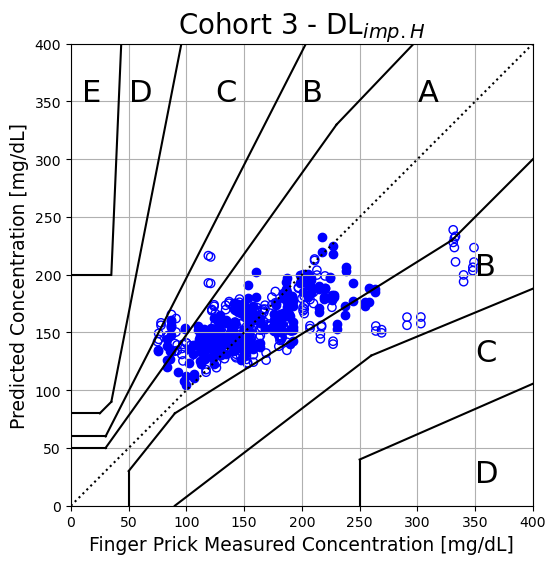

In [55]:
zone_class=['A','b','c','d','B','C','D','E']
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("Cohort 3 - DL$_{imp.H}$" , fontsize =20)
ax=plot_PEG(ax)

ax.scatter(X_sub30,Y_sub30,facecolor='blue',edgecolor='blue')
ax.scatter(X_30to90,Y_30to90,facecolor='none',edgecolor='blue')
plt.grid()


print("Overall MARD : {}".format(mard(X,Y)))
print("<30 Days MARD : {}".format(mard(X_sub30,Y_sub30)))
print("30-90 Days MARD : {} \n".format(mard(X_30to90,Y_30to90)))

zone=[]
for i in range(len(X)):
    zone.append(zone_class[get_PEG_Zone(X[i],Y[i])])
print('Overall Zone% :')
get_zone_ration(zone)

zone=[]
for i in range(len(X_sub30)):
    zone.append(zone_class[get_PEG_Zone(X_sub30[i],Y_sub30[i])])
print('<30 Days Zone% :')
get_zone_ration(zone)

zone=[]
for i in range(len(X_30to90)):
    zone.append(zone_class[get_PEG_Zone(X_30to90[i],Y_30to90[i])])
print('30-90 Days Zone% :')
get_zone_ration(zone)

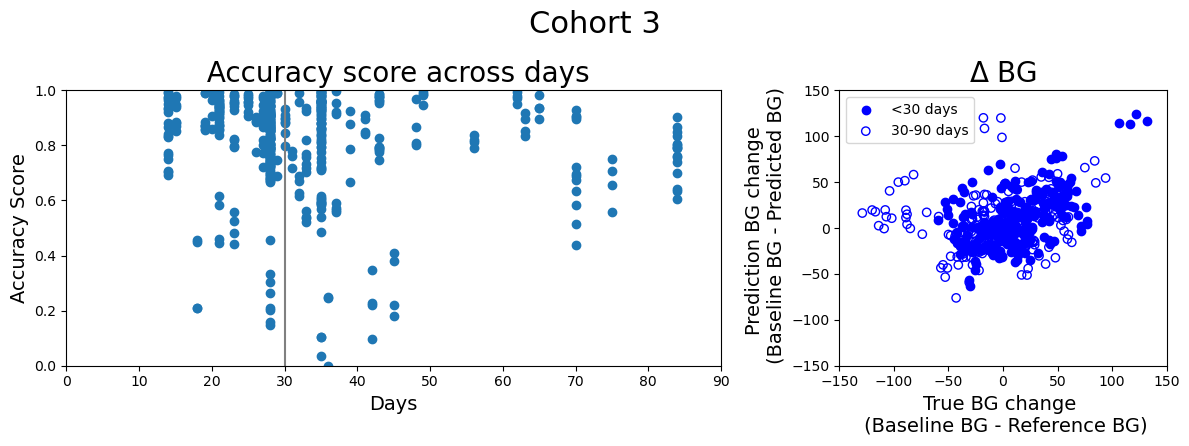

In [26]:
accuracy = 1-(abs(SET3_summary_df['ref_BG']-SET3_summary_df['pred_BG'])/SET3_summary_df['ref_BG'])
SET3_summary_df['accuracy']=accuracy

# Create figure with gridspec
fig = plt.figure(figsize=(12, 4.5), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[4,2])  # Left plot 3x wider than right

# Left subplot (Accuracy across days)
ax1 = plt.subplot(gs[0])
ax1.scatter(SET3_summary_df['date_since_baseline'], accuracy)
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Days", fontsize=14)
ax1.set_ylabel("Accuracy Score", fontsize=14)
ax1.set_title(" Accuracy score across days", fontsize=20)
#ax1.plot([0, 90], [0.8, 0.8], color='grey')
ax1.plot([30, 30], [0, 1], color='grey')

ax2 = plt.subplot(gs[1])

pred_diff_sub30= np.array(Z_sub30)-np.array(Y_sub30)
act_diff_sub30 = np.array(Z_sub30)-np.array(X_sub30)

pred_diff_30to90= np.array(Z_30to90 )-np.array(Y_30to90 )
act_diff_30to90 = np.array(Z_30to90 )-np.array(X_30to90 )

ax2.scatter(act_diff_sub30,pred_diff_sub30,label='<30 days',facecolor='blue',edgecolor ='blue')
ax2.scatter(act_diff_30to90,pred_diff_30to90,label='30-90 days',facecolor='none',edgecolor ='blue')

ax2.set_xlim(-150,150)
ax2.set_ylim(-150,150)
ax2.set_xlabel('True BG change \n (Baseline BG - Reference BG)', fontsize=14)
ax2.set_ylabel('Prediction BG change \n (Baseline BG - Predicted BG)', fontsize=14)
ax2.set_title("$\Delta$ BG" , fontsize =20)
ax2.legend(loc="upper left")

# Overall title
fig.suptitle("Cohort 3", fontsize=22)
plt.tight_layout()
plt.show()

In [31]:
summary_df =SET3_summary_df.loc[SET3_summary_df['date_since_baseline']<=30]
mean_accuracy_score =np.mean(1-abs(summary_df['ref_BG']-summary_df['pred_BG'])/summary_df['ref_BG'])
MAE = np.mean(abs(summary_df['ref_BG']-summary_df['pred_BG']))
MAPE = np.mean(abs(summary_df['ref_BG']-summary_df['pred_BG'])/summary_df['ref_BG'])
RMSE = np.sqrt(np.mean(np.square(summary_df['ref_BG']-summary_df['pred_BG'])))
PCC = np.corrcoef(summary_df['ref_BG'],summary_df['pred_BG'])[0][1]
print('mean_accuracy_score:',mean_accuracy_score)
print('MAE:',MAE)
print('MAPE:',MAPE*100)
print('RMSE:',RMSE)
print('PCC:',PCC)

mean_accuracy_score: 0.8360172054767644
MAE: 22.878310143727656
MAPE: 16.39827945232356
RMSE: 29.376427296960014
PCC: 0.7463187697709738


(0.0, 90.0)

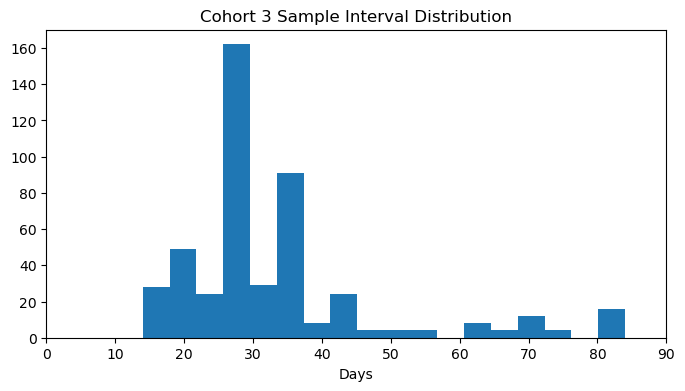

In [32]:
plt.figure(figsize=(8,4))
plt.hist(SET3_summary_df.loc[SET3_summary_df['date_since_baseline']<=90]['date_since_baseline'],bins=18)
plt.title('Cohort 3 Sample Interval Distribution')
plt.xlabel('Days')
plt.xlim(0,90)

1598.0


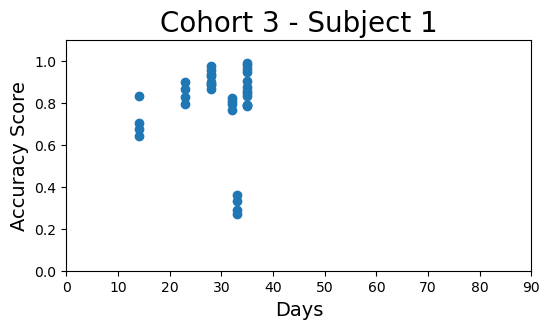

1722.0


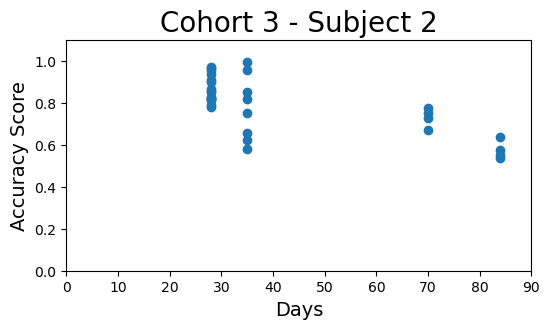

1436.0


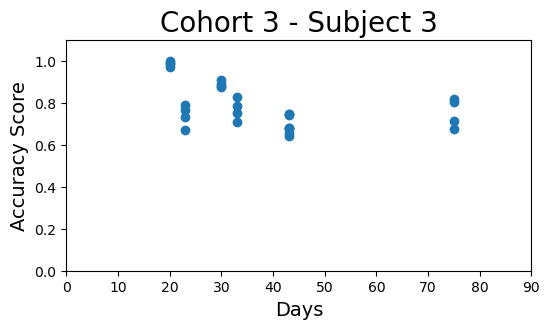

2095.0


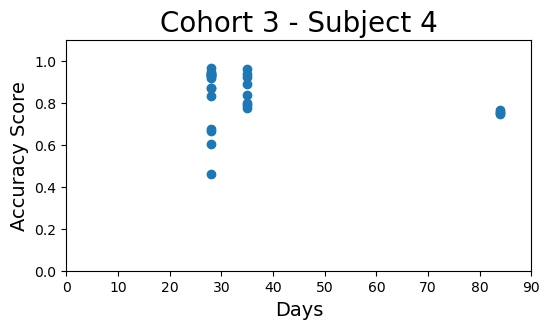

In [191]:
data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set3-All")
data_df[['pid_base', 'col2', 'pid_test', 'col4']] = data_df['pair'].str.split('_', expand=True).astype(int)

data_df=data_df.loc[abs(data_df['delta_days']<=90)]

sample_count=[]
for pid in set3_target_Base:
    set_pids = merge_all.loc[(merge_all['Person No']==pid)|(merge_all['count']==pid) ]['Person No'].values
    sample_count.append(data_df.loc[data_df['pid_base'].isin(set_pids)|data_df['pid_test'].isin(set_pids)].shape[0])

top3_indices = [i for i, _ in sorted(enumerate(sample_count), key=lambda x: x[1], reverse=True)[:4]]
for n, pid in enumerate([list(set(set3_target_Base))[i] for i in top3_indices]):
    print(pid)
    set_pids = merge_all.loc[(merge_all['Person No']==pid)|(merge_all['count']==pid) ]['Person No'].values
    temp_df = data_df.loc[data_df['pid_base'].isin(set_pids)|data_df['pid_test'].isin(set_pids)]
    
    time_interval=temp_df['delta_days']
    Acc_score=1-abs(temp_df['pred_BG']-temp_df['ref_BG'])/temp_df['ref_BG']
    plt.figure(figsize=(6,3))
    plt.title("Cohort 3 - Subject {}".format(n+1), fontsize=20)
    plt.scatter(time_interval,Acc_score)
    plt.xlim(0,90)
    plt.xlabel('Days', fontsize=14)
    plt.ylim(0,1.1)
    plt.ylabel("Accuracy Score", fontsize=14)
    plt.show()
    

1598.0
(72, 14)


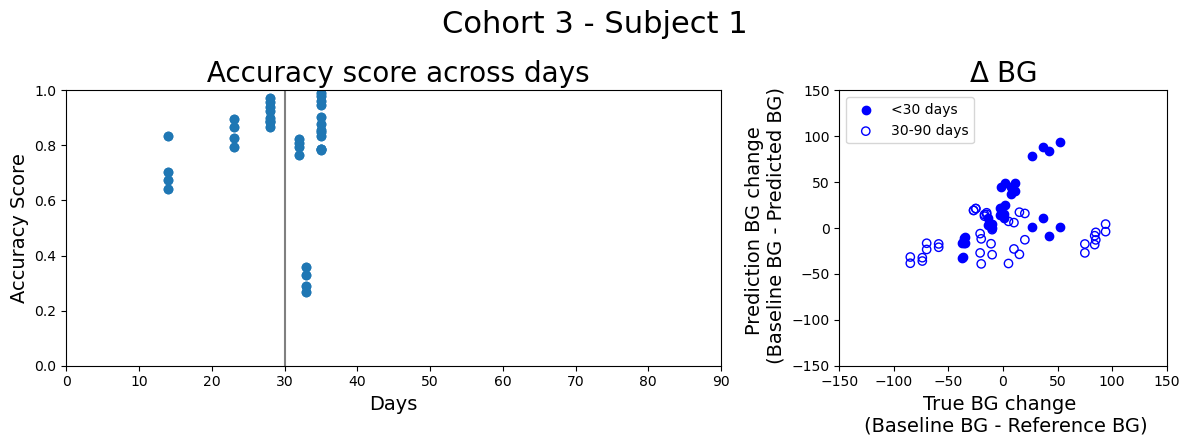

1722.0
(64, 14)


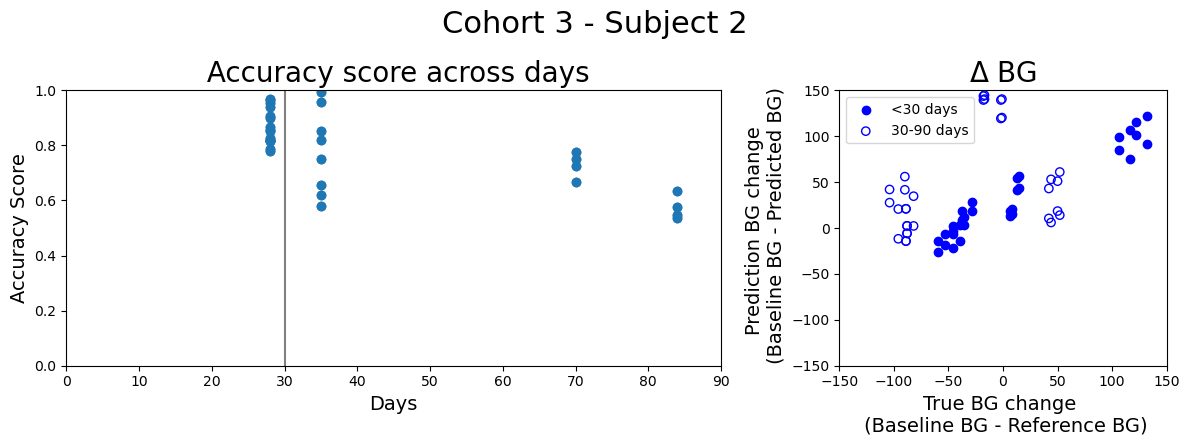

1436.0
(56, 14)


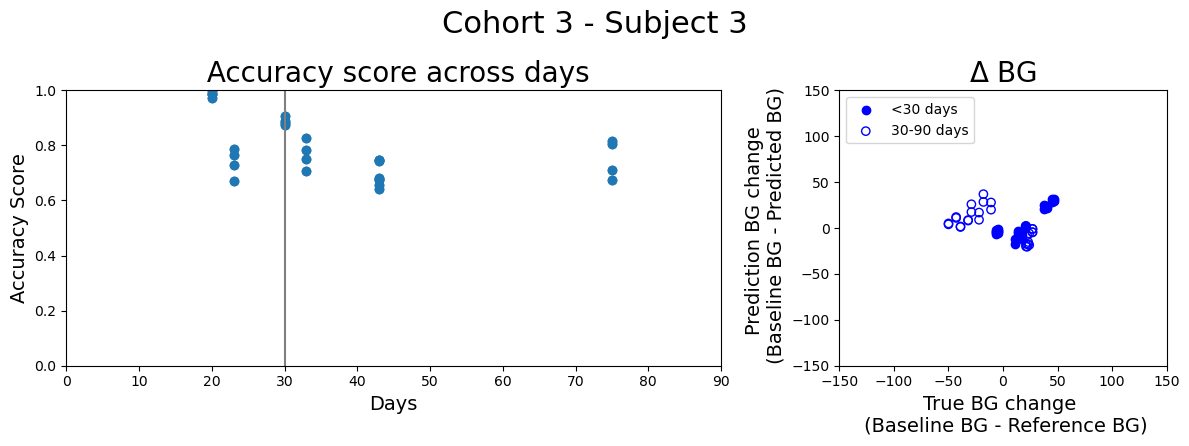

2095.0
(56, 14)


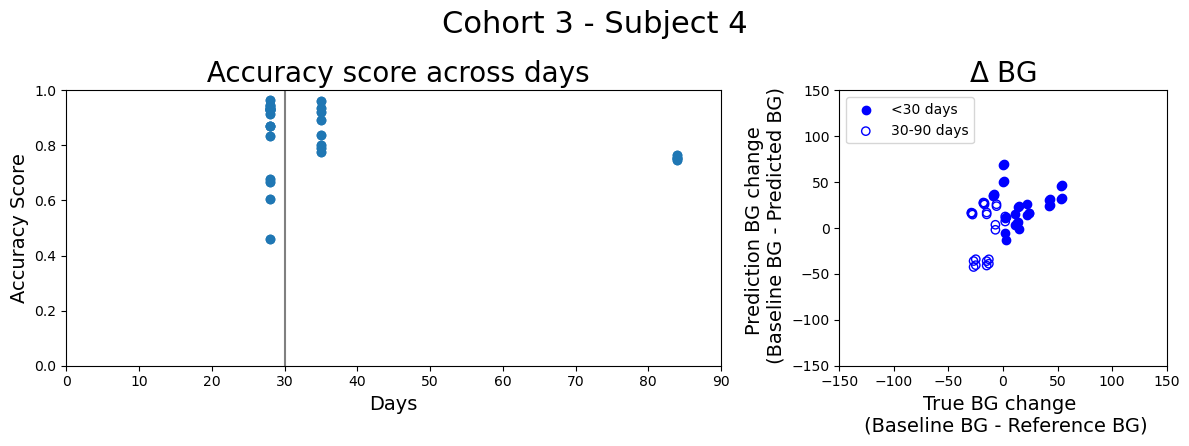

In [194]:
data_df = pd.read_pickle("./result_tables/2024_ImplicitDL_set3-All")
data_df[['pid_base', 'col2', 'pid_test', 'col4']] = data_df['pair'].str.split('_', expand=True).astype(int)
data_df=data_df.merge(merge_all[['Person No', 'BG']],left_on='pid_base',right_on='Person No', how='left')
data_df=data_df.loc[abs(data_df['delta_days']<=90)]


top3_indices = [i for i, _ in sorted(enumerate(sample_count), key=lambda x: x[1], reverse=True)[:4]]
for n, pid in enumerate([list(set(set3_target_Base))[i] for i in top3_indices]):
    print(pid)
    set_pids = merge_all.loc[(merge_all['Person No']==pid)|(merge_all['count']==pid) ]['Person No'].values
    temp_df = data_df.loc[data_df['pid_base'].isin(set_pids)|data_df['pid_test'].isin(set_pids)]
    print(temp_df.shape)
    Acc_score=1-abs(temp_df['pred_BG']-temp_df['ref_BG'])/temp_df['ref_BG']
    # Create figure with gridspec
    fig = plt.figure(figsize=(12, 4.5), dpi=100)
    gs = gridspec.GridSpec(1, 2, width_ratios=[4,2])  # Left plot 3x wider than right

    # Left subplot (Accuracy across days)
    ax1 = plt.subplot(gs[0])
    ax1.scatter(temp_df['delta_days'], Acc_score)
    ax1.set_xlim(0, 90)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Days", fontsize=14)
    ax1.set_ylabel("Accuracy Score", fontsize=14)
    ax1.set_title(" Accuracy score across days", fontsize=20)
    #ax1.plot([0, 90], [0.8, 0.8], color='grey')
    ax1.plot([30, 30], [0, 1], color='grey')

    ax2 = plt.subplot(gs[1])
    
    Y_sub30 = list(temp_df.loc[temp_df['delta_days']<=30]['pred_BG'])
    X_sub30 = list(temp_df.loc[temp_df['delta_days']<=30]['ref_BG'])
    Z_sub30 = list(temp_df.loc[temp_df['delta_days']<=30]['BG'])

    Y_30to90 = list(temp_df.loc[temp_df['delta_days']>30]['pred_BG'])
    X_30to90 = list(temp_df.loc[temp_df['delta_days']>30]['ref_BG'])
    Z_30to90 = list(temp_df.loc[temp_df['delta_days']>30]['BG'])

    pred_diff_sub30= np.array(Z_sub30)-np.array(Y_sub30)
    act_diff_sub30 = np.array(Z_sub30)-np.array(X_sub30)

    pred_diff_30to90= np.array(Z_30to90 )-np.array(Y_30to90 )
    act_diff_30to90 = np.array(Z_30to90 )-np.array(X_30to90 )

    ax2.scatter(act_diff_sub30,pred_diff_sub30,label='<30 days',facecolor='blue',edgecolor ='blue')
    ax2.scatter(act_diff_30to90,pred_diff_30to90,label='30-90 days',facecolor='none',edgecolor ='blue')

    ax2.set_xlim(-150,150)
    ax2.set_ylim(-150,150)
    ax2.set_xlabel('True BG change \n (Baseline BG - Reference BG)', fontsize=14)
    ax2.set_ylabel('Prediction BG change \n (Baseline BG - Predicted BG)', fontsize=14)
    ax2.set_title("$\Delta$ BG" , fontsize =20)
    ax2.legend(loc="upper left")

    # Overall title
    fig.suptitle("Cohort 3 - Subject {}".format(n+1), fontsize=22)
    plt.tight_layout()
    plt.show()